<a href="https://colab.research.google.com/github/iris-kurapaty/CodingPractice/blob/main/Step5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
pwd

'/content'

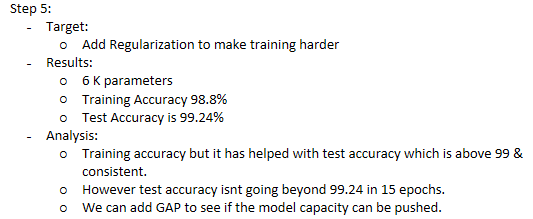

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
from model import *
from utils import *

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train_data = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 416314974.51it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 128594154.80it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 139264828.77it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18658696.15it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


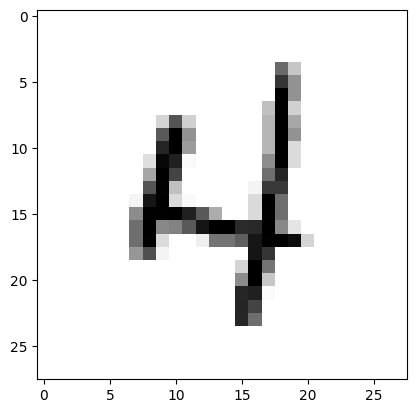

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_set = train_data.train_data
train_set = train_data.transform(train_set.numpy())

print('[Train]')
print(' - Numpy Shape:', train_data.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train_data.train_data.size())
print(' - min:', torch.min(train_set))
print(' - max:', torch.max(train_set))
print(' - mean:', torch.mean(train_set))
print(' - std:', torch.std(train_set))
print(' - var:', torch.var(train_set))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


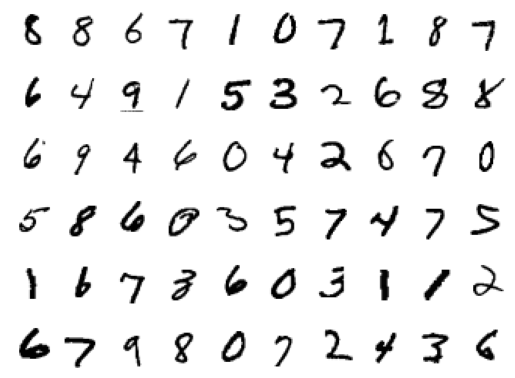

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model

In [ ]:
from model import Net5

# Model Params

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model_summary(Net5, device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10           [-1, 16, 12, 12]           1,152
      BatchNorm2d-11           [-1, 16, 12, 12]              32
          Dropout-12           [-1, 16, 12, 12]               0
             ReLU-13           [-1, 16, 12, 12]               0
           Conv2d-14            [-1, 8,

# Training and Testing


In [ ]:
train_losses_t = []
test_losses_t = []
train_acc_t = []
test_acc_t = []

# Let's Train and test our model

In [ ]:
model =  Net5().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_losses, train_acc = train(model, device, train_loader, optimizer, epoch)
    train_losses_t += train_losses
    train_acc_t.append(train_acc)
    test_losses, test_acc = test(model, device, test_loader)
    test_losses_t += test_losses
    test_acc_t.append(test_acc)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=0.1041276752948761 Batch_id=468 Accuracy=90.86: 100%|██████████| 469/469 [00:18<00:00, 25.87it/s]



Test set: Average loss: 0.0690, Accuracy: 9803/10000 (98.03%)

EPOCH: 1


Loss=0.02662399224936962 Batch_id=468 Accuracy=97.14: 100%|██████████| 469/469 [00:18<00:00, 25.02it/s]



Test set: Average loss: 0.0517, Accuracy: 9845/10000 (98.45%)

EPOCH: 2


Loss=0.059790924191474915 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:20<00:00, 23.44it/s]



Test set: Average loss: 0.0424, Accuracy: 9875/10000 (98.75%)

EPOCH: 3


Loss=0.034120071679353714 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:17<00:00, 26.36it/s]



Test set: Average loss: 0.0385, Accuracy: 9880/10000 (98.80%)

EPOCH: 4


Loss=0.011283338069915771 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:19<00:00, 24.61it/s]



Test set: Average loss: 0.0420, Accuracy: 9861/10000 (98.61%)

EPOCH: 5


Loss=0.1347893625497818 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:17<00:00, 26.61it/s]



Test set: Average loss: 0.0363, Accuracy: 9888/10000 (98.88%)

EPOCH: 6


Loss=0.09524194151163101 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:19<00:00, 23.79it/s]



Test set: Average loss: 0.0299, Accuracy: 9910/10000 (99.10%)

EPOCH: 7


Loss=0.2065775990486145 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:17<00:00, 26.70it/s]



Test set: Average loss: 0.0332, Accuracy: 9901/10000 (99.01%)

EPOCH: 8


Loss=0.022076932713389397 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:18<00:00, 25.03it/s]



Test set: Average loss: 0.0266, Accuracy: 9909/10000 (99.09%)

EPOCH: 9


Loss=0.04944205284118652 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:17<00:00, 26.56it/s]



Test set: Average loss: 0.0263, Accuracy: 9920/10000 (99.20%)

EPOCH: 10


Loss=0.05258399248123169 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:18<00:00, 24.72it/s]



Test set: Average loss: 0.0252, Accuracy: 9922/10000 (99.22%)

EPOCH: 11


Loss=0.03320247307419777 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:17<00:00, 26.51it/s]



Test set: Average loss: 0.0254, Accuracy: 9916/10000 (99.16%)

EPOCH: 12


Loss=0.04010215774178505 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:18<00:00, 25.86it/s]



Test set: Average loss: 0.0253, Accuracy: 9917/10000 (99.17%)

EPOCH: 13


Loss=0.036992065608501434 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:18<00:00, 25.35it/s]



Test set: Average loss: 0.0212, Accuracy: 9924/10000 (99.24%)

EPOCH: 14


Loss=0.021397428587079048 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:18<00:00, 25.98it/s]



Test set: Average loss: 0.0234, Accuracy: 9924/10000 (99.24%)



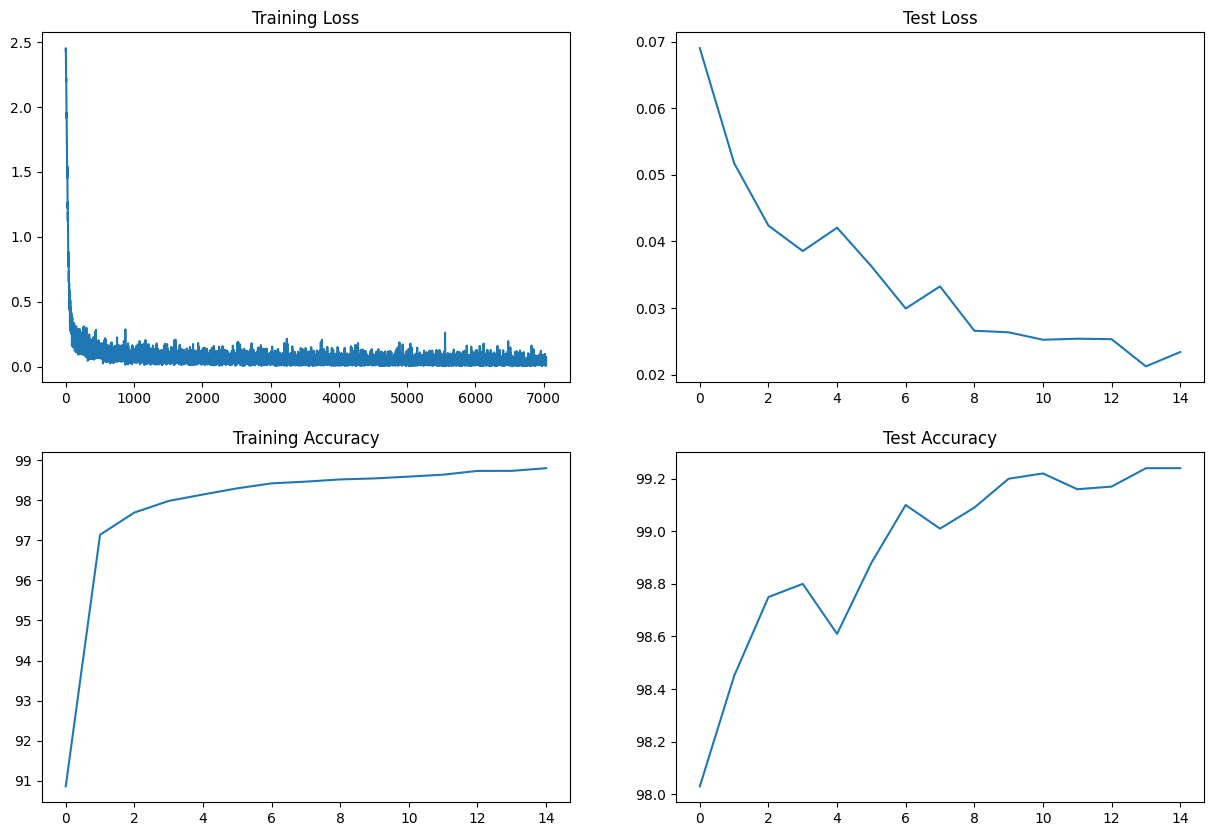

In [ ]:
plot_loss_acc(train_losses_t, train_acc_t, test_losses_t, test_acc_t)